In [1]:
from importlib import reload
import torch
from torch.nn import functional as F
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
#Import graph based
from graph_based.utils.loader import  get_dataset
from graph_based.models.gnn.layers import GraphConvolution
from graph_based.models import resnet
from graph_based.models.hyper_models import HybridGNN
from graph_based.train import train_hybrid
from graph_based.utils.evaluate import eval_normal, eval_hybrid
#Import SSL
from SSL_method import ssl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

In [2]:
def get_data_graph(nodes,links):
    dataset, _ , adj = get_dataset(nodes, links, nodes.shape[0]) 
    return dataset, adj

In [3]:
features = pd.read_csv("./graph_based/dataset/node_2label_balance.csv").to_numpy()
links = pd.read_csv("./graph_based/dataset/edge_2label_balance.csv").to_numpy().astype(float)
links_df = pd.read_csv("./graph_based/dataset/edge_2label_balance.csv")
train_xgb = pd.read_csv("./graph_based/dataset/train.csv").to_numpy()

In [4]:
X_pool, X_gnn_test, X_xgb_pool, X_xgb_test, y_pool, y_test = train_test_split(features, train_xgb, features[:,-1],test_size=0.2, random_state= 42)
X_gnn_train, X_gnn_unlabeled, X_xgb_train, X_xgb_unlabeled, y_train, y_unlabel = train_test_split(X_pool, X_xgb_pool, y_pool, test_size=0.5, random_state= 42)


In [5]:
# dataset_train, nrm_adj_train, adjs_train = get_dataset(X_gnn_train, links, X_gnn_train.shape[0]) 
# dataset_test, nrm_adj_test, adjs_test = get_dataset(X_gnn_test, links, X_gnn_test.shape[0]) 
dataset_train, adjs_train = get_data_graph(X_gnn_train, links)
dataset_val, adj_val = get_data_graph(X_gnn_test, links)


In [6]:
nets = [resnet.ResNet(GraphConvolution,
             in_features=features.shape[1] - 2,
             cfg=[16, 16, 32, 16],
             n_residual_units=[2, 2, 2],
             hidden_layers_fc= [16,8],
             num_classes=None) for _ in range(features.shape[1] - 2)]
model_graph = HybridGNN(2, 'cuda', *nets).cuda()

c:\Users\GroooDev\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
model_graph.load_state_dict(torch.load("mode_new.pt", map_location='cpu'))
pred, f1_resnet_test, acc_resnet_test, prob = eval_hybrid(model_graph, dataset_val.data, dataset_val.targets, adj_val)
print(acc_resnet_test)

0.7581098818676167


In [8]:
XGB1 = xgb.XGBClassifier(eval_metric = "logloss",objective = "binary:logistic", booster = "gbtree", tree_method = "gpu_hist",
                             max_depth = 4, gamma = 2, learning_rate = 0.005, n_estimators = 300, subsample = 0.7 , colsample_bytree = 0.7, min_child_weight = 4, use_label_encoder  = False )
evalset1 = [(X_xgb_train[:,1:-1], y_train), (X_xgb_test[:,1:-1], y_test)]
XGB1 = XGB1.fit(X_xgb_train[:,1:-1], y_train , eval_metric='logloss', eval_set=evalset1)
prediction_test1 = XGB1.predict(X_xgb_test[:,1:-1])
f1_xgb = f1_score(y_test,prediction_test1)
acc_xgb = accuracy_score(y_test,prediction_test1)

[0]	validation_0-logloss:0.69004	validation_1-logloss:0.69002
[1]	validation_0-logloss:0.68693	validation_1-logloss:0.68686
[2]	validation_0-logloss:0.68381	validation_1-logloss:0.68371
[3]	validation_0-logloss:0.68081	validation_1-logloss:0.68068
[4]	validation_0-logloss:0.67797	validation_1-logloss:0.67782
[5]	validation_0-logloss:0.67502	validation_1-logloss:0.67483
[6]	validation_0-logloss:0.67202	validation_1-logloss:0.67183
[7]	validation_0-logloss:0.66905	validation_1-logloss:0.66885
[8]	validation_0-logloss:0.66629	validation_1-logloss:0.66606
[9]	validation_0-logloss:0.66346	validation_1-logloss:0.66322
[10]	validation_0-logloss:0.66056	validation_1-logloss:0.66031
[11]	validation_0-logloss:0.65790	validation_1-logloss:0.65761
[12]	validation_0-logloss:0.65512	validation_1-logloss:0.65481
[13]	validation_0-logloss:0.65250	validation_1-logloss:0.65218
[14]	validation_0-logloss:0.64975	validation_1-logloss:0.64942
[15]	validation_0-logloss:0.64733	validation_1-logloss:0.64697
[1

In [9]:
print(f1_resnet_test, acc_resnet_test)
print(f1_xgb, acc_xgb)

0.8136376769719734 0.7581098818676167
0.8924274593064402 0.8859928745546597


In [10]:
10666/500

21.332

In [11]:
reload(ssl)

<module 'SSL_method.ssl' from 'd:\\AI Project\\Icaller\\SSL_method\\ssl.py'>

In [12]:
model_graph.load_state_dict(torch.load("mode_new.pt", map_location='cpu'))
SSL = ssl.SSLClassifier(estimators= [XGB1,model_graph],
                    X_trains= [X_xgb_train, X_gnn_train],
                    y_train= y_train,
                    X_vals= [X_xgb_test, X_gnn_test],
                    y_val= y_test,
                    links=links,
                    p=30,
                    n=30,
                    k=80,
                    unlabeled_pool_size=500,
                    type_ssl='co2al',
                    type_estimator='gb'
                    )
acc_co2al1,f1_co2al1,acc_co2al2,f1_co2al2 = SSL.fit(X_pools = [X_xgb_unlabeled, X_gnn_unlabeled],
                y_pool = y_pool)

0.8136376769719734 0.7581098818676167
1


100%|██████████| 500/500 [01:05<00:00,  7.64it/s]


0.8716124661246614 0.8578661166322895
2


100%|██████████| 500/500 [01:05<00:00,  7.68it/s]


0.8726039016115352 0.8591786986686668
3


100%|██████████| 500/500 [01:04<00:00,  7.70it/s]


0.8761136325432847 0.8618038627414213
4


100%|██████████| 500/500 [01:04<00:00,  7.71it/s]


0.8756720430107529 0.8612413275829739
5


100%|██████████| 500/500 [01:05<00:00,  7.68it/s]


0.8746395250212045 0.8614288393024564
6


100%|██████████| 500/500 [01:06<00:00,  7.56it/s]


0.876855600539811 0.8631164447777986
7


100%|██████████| 500/500 [01:06<00:00,  7.51it/s]


0.8755698125949688 0.8618038627414213
8


100%|██████████| 500/500 [01:06<00:00,  7.56it/s]


0.8761390482618968 0.8623663978998687
9


100%|██████████| 500/500 [01:05<00:00,  7.64it/s]


0.8756118143459917 0.8618038627414213
10


100%|██████████| 500/500 [01:06<00:00,  7.56it/s]


0.8752521856086078 0.860866304144009
11


100%|██████████| 500/500 [01:05<00:00,  7.61it/s]


0.8743261455525607 0.8601162572660791
12


100%|██████████| 500/500 [01:05<00:00,  7.62it/s]


0.8749578699022582 0.860866304144009
13


100%|██████████| 500/500 [01:06<00:00,  7.56it/s]


0.875993909659956 0.8625539096193512
14


100%|██████████| 500/500 [01:05<00:00,  7.58it/s]


0.8766244725738397 0.8629289330583162
15


100%|██████████| 500/500 [01:06<00:00,  7.46it/s]


0.8766937669376694 0.8634914682167636
16


100%|██████████| 500/500 [01:06<00:00,  7.56it/s]


0.8774193548387097 0.8646165385336584
17


100%|██████████| 500/500 [01:06<00:00,  7.49it/s]


0.8768054375531011 0.864054003375211
18


100%|██████████| 500/500 [01:06<00:00,  7.54it/s]


0.876465590484282 0.863678979936246
19


100%|██████████| 500/500 [01:05<00:00,  7.58it/s]


0.8773120651620567 0.8644290268141759
20


100%|██████████| 500/500 [01:06<00:00,  7.51it/s]


0.8773360516479782 0.8646165385336584
21


100%|██████████| 500/500 [01:06<00:00,  7.48it/s]


0.8771691051378019 0.8646165385336584


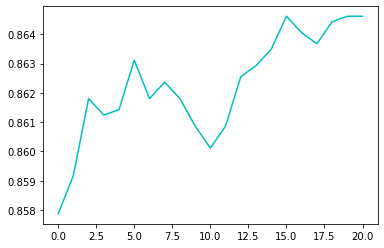

In [20]:
hnd2, = plt.plot(acc_co2al2,'c',label='Co2AL')

In [14]:
# model_graph.load_state_dict(torch.load("mode_new.pt", map_location='cpu'))
# SSL = ssl.SSLClassifier(estimators= [XGB1,model_graph],
#                     X_trains= [X_xgb_train, X_gnn_train],
#                     y_train= y_train,
#                     X_vals= [X_xgb_test, X_gnn_test],
#                     y_val= y_test,
#                     links=links,
#                     p=30,
#                     n=30,
#                     k=30,
#                     unlabeled_pool_size=300,
#                     type_ssl='al',
#                     type_estimator='gb'
#                     )
# acc_al1,f1_al1,acc_al2,f1_al2 = SSL.fit(X_pools = [X_xgb_unlabeled, X_gnn_unlabeled],
#                 y_pool = y_pool)

In [15]:
# model_graph.load_state_dict(torch.load("mode_new.pt", map_location='cpu'))
# SSL = ssl.SSLClassifier(estimators= [XGB1,model_graph],
#                     X_trains= [X_xgb_train, X_gnn_train],
#                     y_train= y_train,
#                     X_vals= [X_xgb_test, X_gnn_test],
#                     y_val= y_test,
#                     links=links,
#                     p=50,
#                     n=50,
#                     k=30,
#                     unlabeled_pool_size=500,
#                     type_ssl='coal',
#                     type_estimator='gb'
#                     )
# acc_coal1,f1_coal1,acc_coal2,f1_coal2 = SSL.fit(X_pools = [X_xgb_unlabeled, X_gnn_unlabeled],
#                 y_pool = y_pool)

In [16]:
# reload(ssl)

In [17]:

# hnd1, = plt.plot(acc_al2,'g',label='Active learning')
# hnd2, = plt.plot(acc_coal2,'b',label='SLLCA')
# hnd2, = plt.plot(acc_co2al2,'c',label='Cotrain2AL')

# plt.legend(loc='best')
# plt.ylabel('Accuracy')
# plt.xlabel('Iteration')
# plt.title('Cotrain to ActiveLearning')
# plt.rcParams["figure.figsize"] = (10,10)
# plt.show()

In [2]:
# pd.DataFrame({'acc_co2al2': acc_co2al2}).to_csv("output.csv")

In [4]:
output = pd.read_excel("output.xlsx")[['acc_co2al2','acc_al2','acc_coal2']]
output

,acc_co2al2,acc_al2,acc_coal2
0,0.857866,0.857304,0.858420
1,0.859179,0.858429,0.861610
2,0.861804,0.863304,0.862075
3,0.861241,0.860866,0.860660
4,0.861429,0.863116,0.861051
5,0.863116,0.861429,0.864340
6,0.861804,0.859929,0.863831
7,0.862366,0.862179,0.862063
8,0.861804,0.859741,0.861552
9,0.860866,0.860679,0.861423


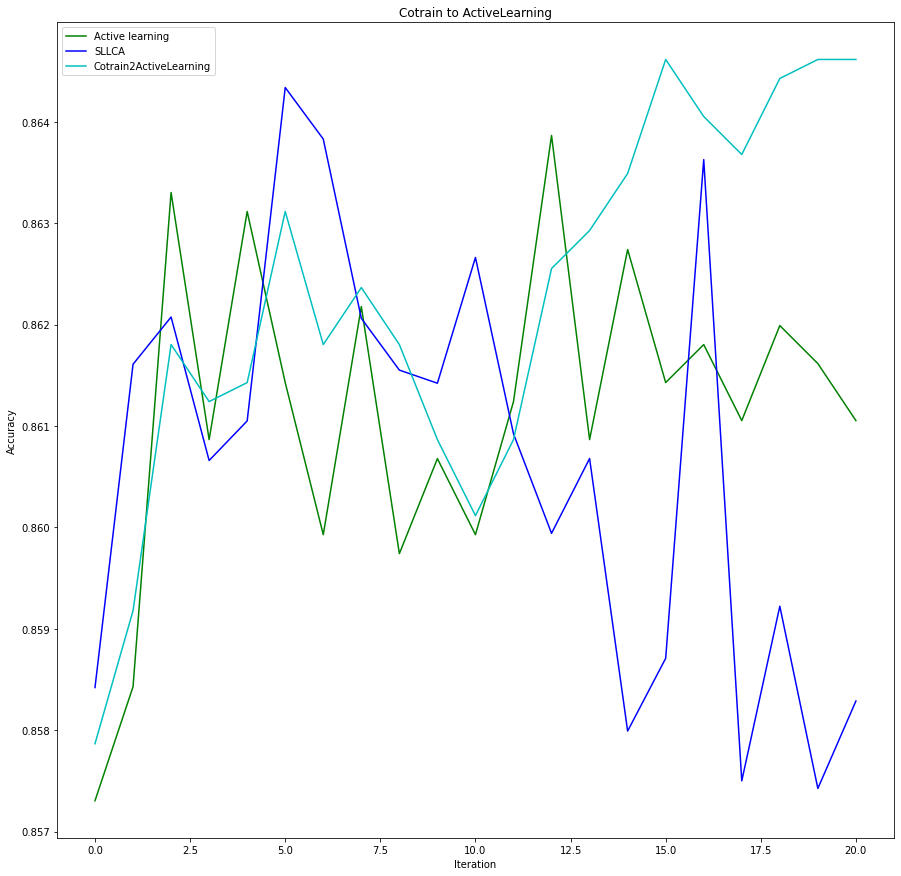

In [12]:
hnd1, = plt.plot(output.acc_al2,'g',label='Active learning')
hnd2, = plt.plot(output.acc_coal2,'b',label='SLLCA')
hnd2, = plt.plot(output.acc_co2al2,'c',label='Cotrain2ActiveLearning')

plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.title('Cotrain to ActiveLearning')
plt.rcParams["figure.figsize"] = (15,15)
plt.show()